# Spatiotemporal Rainfall Model Example

This workbook provides an example of how to set up and run a spatiotemporal rainfall model. It assumes that you have read the rainfall model overview in the documentation and tried the single site model workbook. The example demonstrates how to:
 - Change the probability distribution used for sampling raincell intensity
 - Use multiple gauge time series to set up a rainfall model
 - Make changes to the fitting procedure (adjusted parameter bounds and "fixed" parameters)
 - Get catchment-average time series outputs, as well as simulated series for gauge locations

The example is for a 2800 km$^{\mathrm{2}}$ catchment in the (eastern) Rhine basin (close to the border between Germany and the Czech Republic). Three sub-catchments are considered (shown in red in the map below). The model is set up using hourly gauge data from the Deutsche Wetterdienst.

<div>
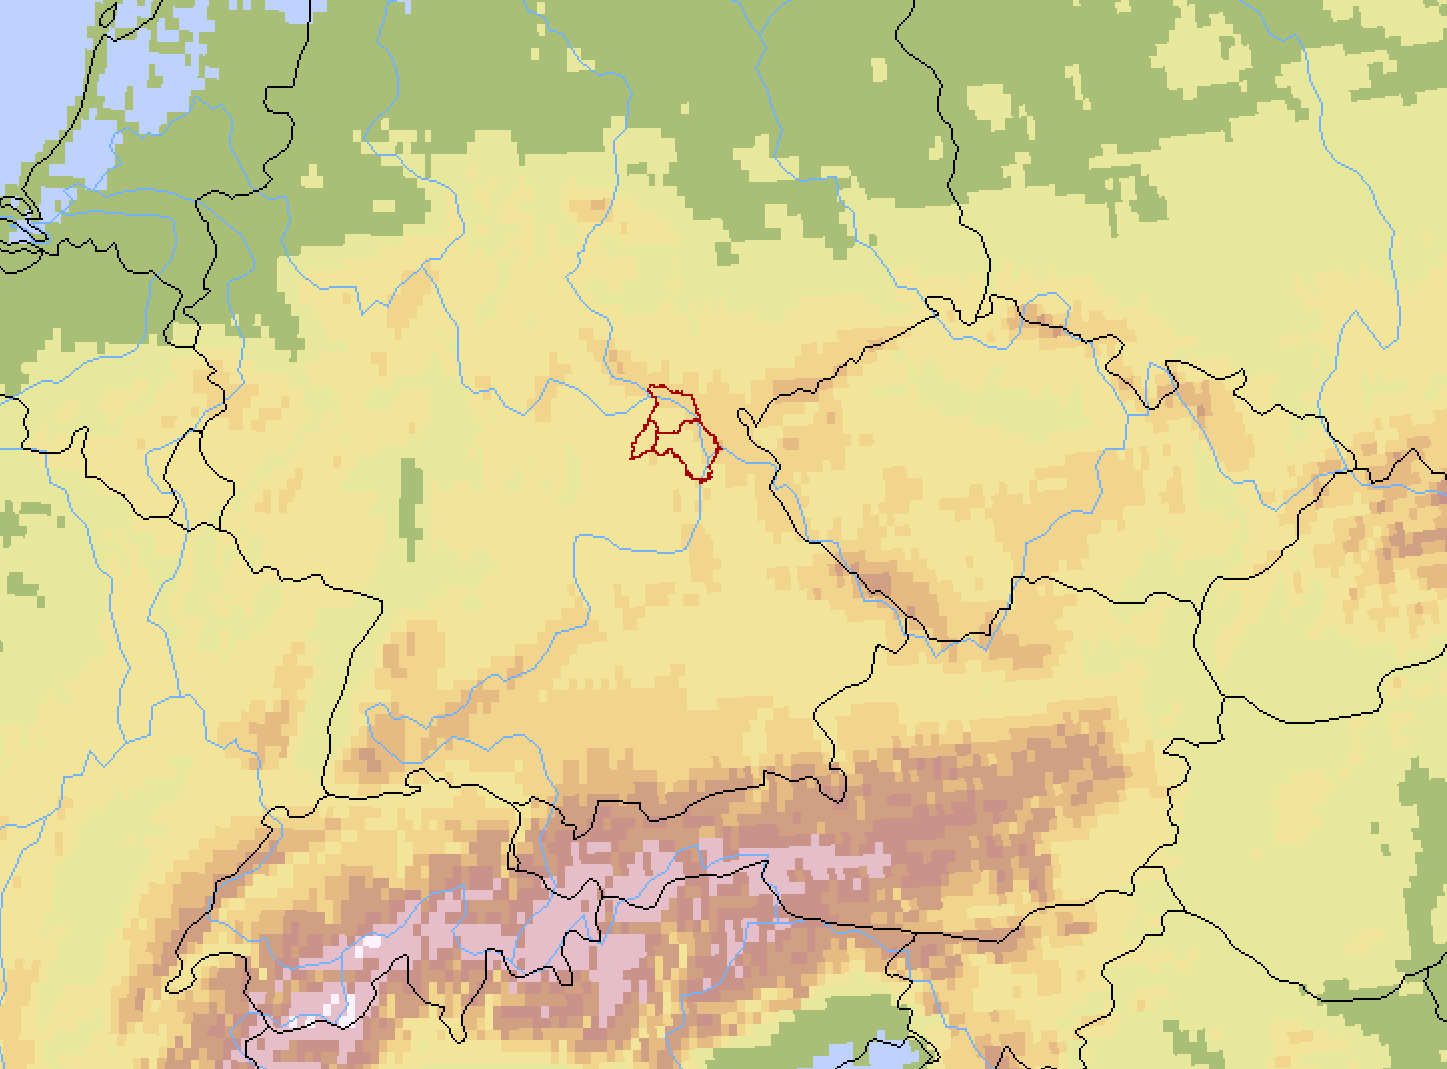
</div>

## Data Requirements

The minimal data requirements for a spatiotemporal model based on gauge data are:
 - A `.csv` file containing basic gauge metadata (location, name, ID, elevation) - see below
 - Files containing gauge time series (one file per gauge currently - same format as single site example)

Optional data files are:
 - A DEM - good if available.
 - A polygon shapefile containing catchment/sub-catchment boundaries if catchment-average outputs are requested.

These data files need to be prepared before setting up the rainfall model. See the documentation for a more complete description of these files.

## Initialisation

For this example we will accept the default definitions of statistics and weights to be used in model fitting. We do want to change the probability distribution used for raincell intensity, which means we can initialise the model as follows:

In [1]:
import rwgen

rainfall_model = rwgen.RainfallModel(
    spatial_model=True,
    project_name='upper_rhine',
    intensity_distribution='weibull',
    point_metadata='./input/gauge_metadata.csv',
)

Note that we have to specify `point_metadata` when initialising a spatial model. This file can be prepared in Excel and looks something like:

<div>
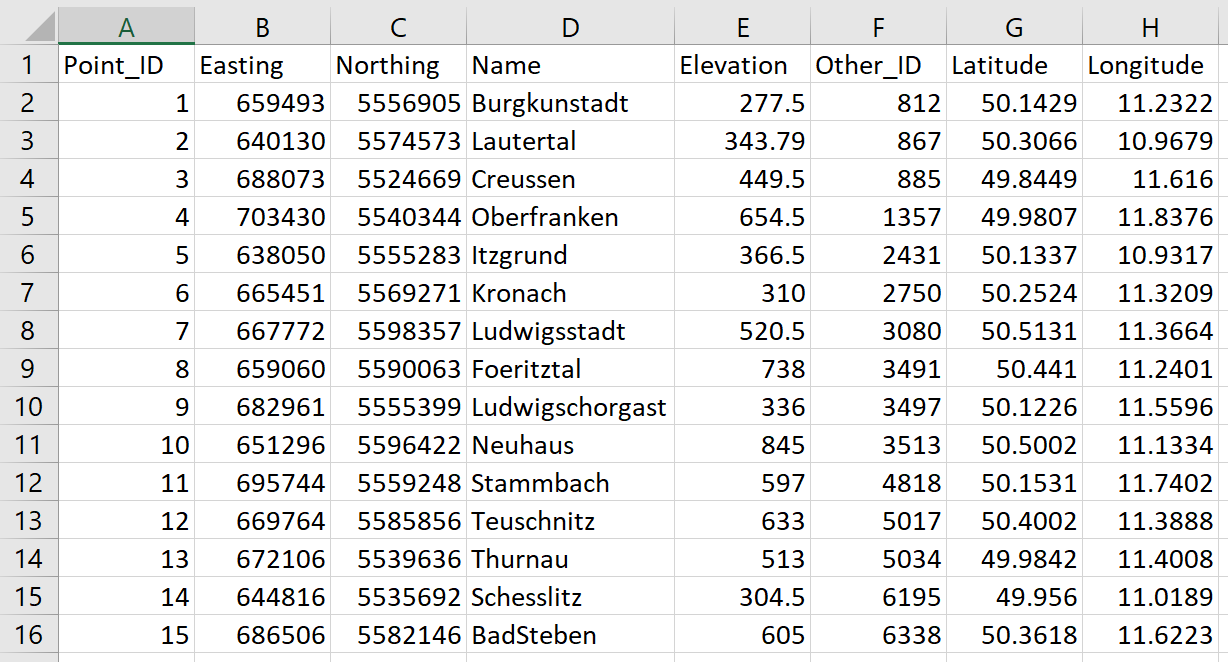
</div>

The `Other_ID`, `Latitude` and `Longitude` fields are ignored by the model.

## Preprocessing

Prior inspection of the gauge time series data revealed one or two "outliers" with a very large influence on the skewness. This time in preprocessing then we will "trim" the data. By default this will look at the largest value in each month/season and remove it if it is over two times the size of the next largest value (removing up to five values). These details can be adjusted using arguments to the preprocess method. 

In [2]:
rainfall_model.preprocess(
    input_timeseries='./input/gauge_data',
    outlier_method='trim',
)

Preprocessing
  - Completed


We can see here that the `input_timeseries` argument is a path to the folder containing the time series data files. This is different to the single site example, where we just provided a path to a single file.

## Fitting

With no prior knowledge of suitable parameter values, we could do fitting in the default way (as per the single site example). This would take the form of:

```python
rainfall_model.fit(
    n_workers=6,  # for a 6-core computer
)
```

To speed things up and demonstrate additional functionality, we will instead (1) place custom bounds on parameter ranges and (2) fix particular parameters. The ranges and values selected are based on an initial call to fit that I did using the lines above.

To place custom bounds on parameter ranges we can use a table like:
INSERT

To fix particular parameter values we can use a table like:
INSERT

In the fit call itself we can specify these files as follows:

In [3]:
rainfall_model.fit(
    n_workers=6,  # for a 6-core computer
    parameter_bounds='./input/fitting/parameter_bounds.csv',
    fixed_parameters='./input/fitting/fixed_parameters.csv',
)

Fitting
  - Month = 1 2 3 4 5 6 7 8 9 10 11 12
  - Completed


## Simulation

If we just wanted to simulate stochastic time series for a set of gauge locations (i.e. those ones we specified earlier by setting `point_metadata` on initialisation), then we could call the `simulate` method in the same way that we did for the single site case:

```python
rainfall_model.simulate(
    simulation_length=500,
    n_realisations=2,
)
```

Note that the call above uses the default timestep of one hour.

If we want to produce additional catchment-average time series outputs there are a few extra options to specify. (Ultimately it will also be possible to write gridded output, but this option is not yet fully implemented.)

The code cell below indicates the extra options that can be specified:
 - `output_types` is a list (square brackets) indicating that we want both point (gauge) and catchment-average outputs
 - `catchment_metadata` points the model to the catchment shapefile discussed above
 - `epsg_code` refers to the EPSG code for the coordinate system of the catchment shapefile. This example in Germany uses the "WGS 84 / UTM zone 32N" coordinate system (https://epsg.io/32632). The code for the "British National Grid" would be 27700 (https://epsg.io/27700)
 - `cell_size` refers to the grid cell size (in metres) used to discretise the NSRP process when calculating catchment-average outputs (and ultimately gridded outputs if requested)
 - `dem` is specified as an ascii raster (which can be a different resolution to the `cell_size`)


In [6]:
rainfall_model.simulate(
    output_types=['point', 'catchment'],
    catchment_metadata='./input/catchments.shp',
    epsg_code=32632,
    cell_size=1000.0,
    dem='./input/srtm_dem.asc',
    simulation_length=500,
    n_realisations=2,
)

Simulating
  - Initialising
  - Realisation = 1 [Block = 1/1]
    - Sampling
    - Discretising = 0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100%
    - Writing
  - Realisation = 2 [Block = 1/1]
    - Sampling
    - Discretising = 0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100%
    - Writing
  - Completed


## Post-Processing

As in the single site example we can now do some post-processing to calculate/extract statistics of interest. The post-processing only runs for point (gauge) locations currently.

In [7]:
rainfall_model.postprocess(
    amax_durations=[1, 3, 6, 24],
    ddf_return_periods=[2, 5],
)

Post-processing
  - Completed
